Importing necessary modules

In [282]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

In [283]:
# input given 

FRD = '''
speed - [50, 100]
acceleration - [0, 5] 
time - [0, 3]
if speed > 75, 
then distance = speed * time
else, 
distance = 0.5 * acceleration * time^2
end
'''

<div class="alert alert-block alert-info">
<i>Yet to integrate the Few-shot prompting API calling part, the code for API call is available at <a href="https://colab.research.google.com/drive/1QOxmksOYcsZDx7V-tKGBNL2ISUxiDLD3#scrollTo=ORe-LJwKNbxI">Notebook File for Few-shot prompting response</a> https://colab.research.google.com/drive/1QOxmksOYcsZDx7V-tKGBNL2ISUxiDLD3#scrollTo=ORe-LJwKNbxI</i>
</div>

In [284]:
# output from few shot prompting

dict_from_few_shot_prompting = {
  "variables": ["speed", "acceleration", "distance", "time"],
  "equations": [
    {"equation": "distance = speed * time", "condition": "speed > 75"},
    {"equation": "distance = 0.5 * acceleration * time^2", "condition": "speed <= 75"}
  ],
  "ranges": {
    "speed": [50, 100],
    "acceleration": [0, 5],
    "time": [0, 3]
  }
}

In [285]:
# extracting the necessary details from few shot prompting api call 

variables = dict_from_few_shot_prompting['variables']
equations = dict_from_few_shot_prompting['equations']
ranges = dict_from_few_shot_prompting['ranges']
independant_variables = [var for var in ranges.keys()]

In [286]:
dependant_variables = []
for equation in equations:
    variable = equation['equation'].split('=')[0].strip()
    dependant_variables.append(variable)

dependant_variables = list(set(dependant_variables))

In [287]:
miscellaneous_variables = [var for var in variables if var not in dependant_variables and var not in independant_variables]

if len(miscellaneous_variables) > 0:
    raise Exception(f'Variable/s missing for implementation: {miscellaneous_variables}')

In [288]:
confusables = [
    ('^', '**')
]

# remove confusables
def pre_process_equations(equations):
    for equation in equations:
        for confusable in confusables:
            equation['equation'] = equation['equation'].replace(confusable[0], confusable[1])
            equation['condition'] = equation['condition'].replace(confusable[0], confusable[1])

# generate the list of values for each independant variables
def pre_process_ranges(ranges):
    processed_ranges = {}
    for var, range_value in ranges.items():
        if isinstance(range_value[0], int) and isinstance(range_value[1], int):
            processed_ranges[var] = list(range(range_value[0], range_value[1] + 1))
        else:
            processed_ranges[var] = range_value
    return processed_ranges

# adding pre requisites required for calculating each dependant variable
def add_pre_requisites(equations):
    for equation in equations:
        equation['calculation_pre_requisites'] = []
        equation['condition_pre_requisites'] = []
        rhs = equation['equation'].split('=')[1]
        condition = equation['condition']
        for var in variables:
            if var in rhs:
                equation['calculation_pre_requisites'].append(var)
            if var in condition:
                equation['condition_pre_requisites'].append(var)

def add_equation_conditions(equations):
    equations_dict = {}
    for equation in equations:
        lhs = equation['equation'].split('=')[0].strip()
        if lhs in equations_dict:
            equations_dict[lhs].append(equation)
        else:
            equations_dict[lhs] = [equation]
    return equations_dict

Yet to implement the cycling dependancy check

In [289]:
def check_cyclic_dependancy(equations):
    for equation in equations:
        lhs = equation['equation'].split('=')[0].strip()
        pre_requisites = set(equation['calculation_pre_requisites'] + equation['condition_pre_requisites'])

        # yet to implement

In [290]:
# pre processing

pre_process_equations(equations)
add_pre_requisites(equations)
ranges = pre_process_ranges(ranges)

equations_dict = add_equation_conditions(equations)

In [291]:
variables = independant_variables+dependant_variables

In [292]:
# creating data frame for the test cases

test_cases_df = pd.DataFrame(columns=variables)

In [293]:
test_cases_df

,speed,acceleration,time,distance


In [294]:
independant_variable_combinations = list(itertools.product(*ranges.values()))

In [295]:
# generating different combinations of independent variables

for combination in independant_variable_combinations:
    new_row = dict(zip(ranges.keys(), combination))
    new_row_df = pd.DataFrame([new_row])
    test_cases_df = pd.concat([test_cases_df, new_row_df], ignore_index=True)


In [296]:
test_cases_df.sample(15)

,speed,acceleration,time,distance
389,66,1,1,NaN
699,79,0,3,NaN
932,88,5,0,NaN
190,57,5,2,NaN
448,68,4,0,NaN
74,53,0,2,NaN
84,53,3,0,NaN
1164,98,3,0,NaN
301,62,3,1,NaN
201,58,2,1,NaN


Sorting the dependent variables based on the number of in-degrees

In [297]:
def sort_keys(key):
    equations = equations_dict[key]
    cumulative_prerequisites = sum(
        len(eq.get('calculation_pre_requisites', [])) + len(eq.get('condition_pre_requisites', []))
        for eq in equations
    )
    return cumulative_prerequisites

sorted_keys = sorted(equations_dict.keys(), key=sort_keys)

sorted_equations_dict = {key: equations_dict[key] for key in sorted_keys}

In [298]:
def sort_dependant_variables(dependant_variable):
    return sorted_keys.index(dependant_variable)

# Sort the list of dependent variables based on the custom key function
dependant_variables = sorted(dependant_variables, key=sort_dependant_variables)


## Yet to write Algorithm for implementing Graph Dependancy Model for Finding cyclic dependency and to start filling from 0 in-degree


In [299]:
for variable in dependant_variables:
    equations = equations_dict.get(variable, [])
    
    for index, row in test_cases_df.iterrows():

        for equation_info in equations:
            equation = equation_info['equation']
            equation_rhs = equation.split('=')[1]
            condition = equation_info['condition']
            calculation_pre_requisites = equation_info['calculation_pre_requisites']
            condition_pre_requisites = equation_info['condition_pre_requisites']

            # Check if condition matches
            if eval(condition, row[condition_pre_requisites].to_dict()):

                # Calculate value using eval
                calculated_value = eval(equation_rhs, row[calculation_pre_requisites].to_dict())
                test_cases_df.at[index, variable] = calculated_value

In [300]:
test_cases_df.sample(20)

,speed,acceleration,time,distance
406,66,5,2,10.0
441,68,2,1,1.0
1002,91,4,2,182
859,85,4,3,255
199,58,1,3,4.5
687,78,3,3,234
887,86,5,3,258
103,54,1,3,4.5
1185,99,2,1,99
914,88,0,2,176


In [301]:
test_cases_df.describe(include = 'all')

,speed,acceleration,time,distance
count,1224,1224,1224,1224.0
unique,51,6,4,90.0
top,50,0,0,0.0
freq,24,204,306,384.0


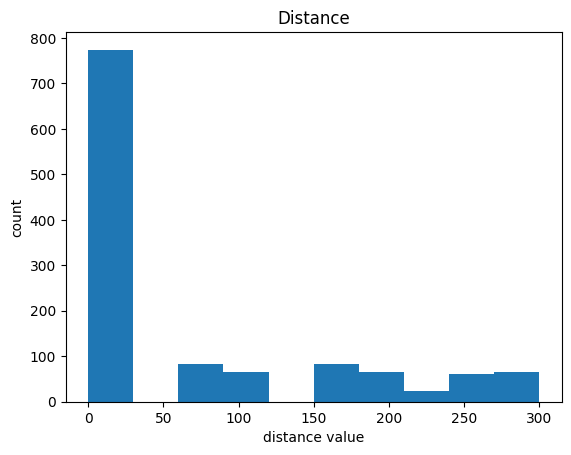

In [302]:
for variable in dependant_variables:
    plt.hist(test_cases_df[variable])
    plt.title(variable.capitalize())
    plt.xlabel(f'{variable} value')
    plt.ylabel('count')
    plt.show() 

In [303]:
# printing statistics

for dependent_variable in dependant_variables:
    print(f"Statistics for {dependent_variable}:")
    print(f"Minimum: {test_cases_df[dependent_variable].min()}")
    print(f"Maximum: {test_cases_df[dependent_variable].max()}")
    print(f"Median: {test_cases_df[dependent_variable].median()}")
    print(f"Unique values: {test_cases_df[dependent_variable].nunique()}")
    print()

Statistics for distance:
Minimum: 0.0
Maximum: 300
Median: 6.0
Unique values: 90



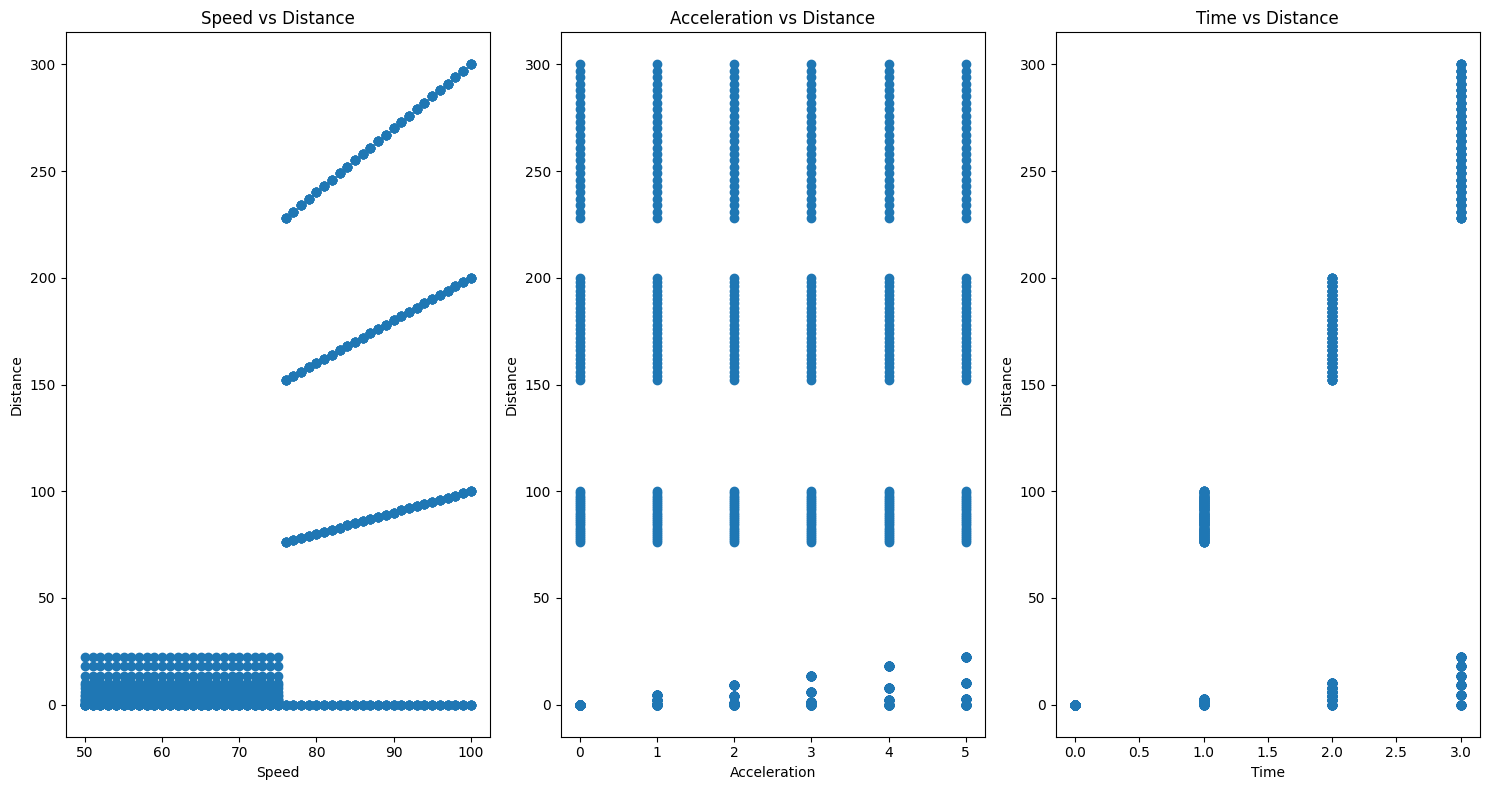

In [304]:
num_variables = len(independant_variables)
num_dependent_variables = len(dependant_variables)

fig, axs = plt.subplots(num_dependent_variables, num_variables, figsize=(15, 8))

if num_dependent_variables == 1:
    axs = axs.reshape(1, num_variables)

for j, dependent_variable in enumerate(dependant_variables):
    for i, independent_variable in enumerate(independant_variables):
        axs[j, i].scatter(test_cases_df[independent_variable], test_cases_df[dependent_variable])
        axs[j, i].set_title(f'{independent_variable.capitalize()} vs {dependent_variable.capitalize()}')
        axs[j, i].set_xlabel(f'{independent_variable.capitalize()}')
        axs[j, i].set_ylabel(f'{dependent_variable.capitalize()}')

plt.tight_layout()
plt.show()